In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import numpy as np
import pickle

sys.path.append('D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin')
from models import *
from clients_datasets import *
from tqdm.notebook import tqdm
from utils import *
from AttFunc import *
from Fisher_LeNet import *

In [7]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'cifar10'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
am = ResNet_9().cuda()

att_type = 'sign'
acc0 = 85.52
betas = []

for i in range(10):
    beta = simulated_annealing(dataset, 1, 500, att_type, acc0,  clients_testloader[8])
    betas.append(beta)
    print(beta)

beta_mean, beta_range = data_process(betas)
print('------------------------------------')
print(beta_mean)

0.5366511221421068
0.10664343402692975
1.8086893394542378
0.6076015131602669
1.0100300942730822
0.9985446692472139
0.25329465244245264
0.46129257946276386
1.6222138153381322
1.1523115264646737
------------------------------------
0.872058758893521


In [9]:
alpha = [0.2, 0.4, 0.6, 0.8]
alpha = [0.1, 0.3, 0.5, 0.7, 0.9]

In [10]:
att_type = 'sign'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 5
mode = 'Basic'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'cifar10'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 6

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [8]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]
                mal_params = perturbation(beta=beta, bp=benign_params, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

basic_acc1=acc1_varying
print(acc1_varying)
print(drop_varying)

Training:   0%|          | 0/5 [00:00<?, ?iter/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[13.920000000000002, 12.66, 14.763333333333332, 15.232499999999998, 16.412]
[71.6, 72.85999999999999, 70.75666666666666, 70.2875, 69.10799999999999]


In [11]:
att_type = 'sign'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 5
mode = 'Fisher'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'cifar10'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 6

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [8]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id :
                benign_params = list(client.parameters())[:2]

                fisher_matrix = {}
                for param_name, param in client.named_parameters():
                    if param_name == 'conv1.0.weight':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                    if param_name == 'conv1.0.bias':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(fisher_matrix['conv1.0.weight'], alpha[iter]))
                bias_positions.append(find_positions(fisher_matrix['conv1.0.bias'], alpha[iter]))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

fisher_acc1=acc1_varying
print(acc1_varying)
print(drop_varying)

Training:   0%|          | 0/5 [00:00<?, ?iter/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[14.469999999999999, 12.505, 12.016666666666664, 11.885000000000002, 11.628]
[71.05, 73.015, 73.50333333333332, 73.63499999999999, 73.892]


In [12]:
att_type = 'sign'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 5
mode = 'Taylor'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'svhn'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 6

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [8]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]

                Taylor_scores = {}
                for param_name, param in client.named_parameters():
                    if param.grad is not None:
                        Taylor_scores[param_name] = torch.abs(param * param.grad)

                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(Taylor_scores['conv1.0.weight'].cpu().detach().numpy(), alpha[iter]))
                bias_positions.append(find_positions(Taylor_scores['conv1.0.bias'].cpu().detach().numpy(), alpha[iter]))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

taylor_acc1=acc1_varying
print(acc1_varying)
print(drop_varying)

Training:   0%|          | 0/5 [00:00<?, ?iter/s]

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
[67.49001949186598, 68.19493547855983, 69.27500448004086, 66.29342516876132, 65.48173028521386]
[18.029980508134003, 17.32506452144016, 16.244995519959144, 19.22657483123868, 20.03826971478614]


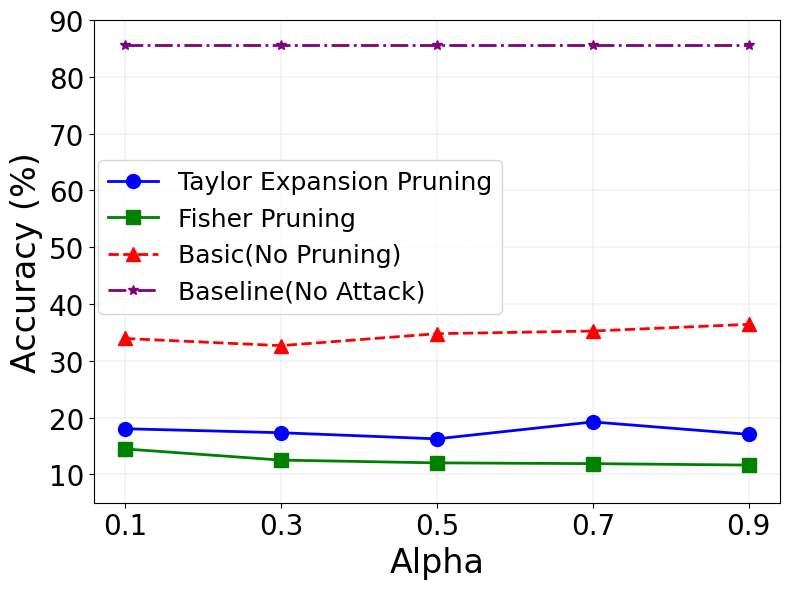

In [29]:
baseline = [acc0] * 5
baseline = [85.52] * 5
alpha = [0.1, 0.3, 0.5, 0.7, 0.9]
basic_acc1 = [33.920000000000002, 32.66, 34.763333333333332, 35.232499999999998, 36.412]
fisher_acc1 = [14.469999999999999, 12.505, 12.016666666666664, 11.885000000000002, 11.628]
taylor_acc1 = [18.029980508134003, 17.32506452144016, 16.244995519959144, 19.22657483123868, 17.03826971478614]


plt.figure(figsize=(8, 6))
plt.plot(alpha, taylor_acc1, marker='o', markersize=10, label='Taylor Expansion Pruning', color='blue', linestyle='-', linewidth=2)
plt.plot(alpha, fisher_acc1, marker='s', markersize=10, label='Fisher Pruning', color='green', linestyle='-', linewidth=2)
plt.plot(alpha, basic_acc1, marker='^', markersize=10, label='Basic(No Pruning)', color='red', linestyle='--', linewidth=2)
plt.plot(alpha, baseline, marker='*', markersize=7, label='Baseline(No Attack)', color='purple', linestyle='-.', linewidth=2)

plt.xticks(alpha, fontsize=20)  # Mark all client IDs
plt.yticks(fontsize=20)
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Accuracy (%)', fontsize=24)
plt.ylim(5, 90)
plt.legend(fontsize=18, loc='center', bbox_to_anchor=(0.3, 0.55))

plt.grid(True, linestyle=':', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()